In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x


In [6]:
N_Agents = 1
in_dim = 1
batch_size = 32
n_samples = 128
timesteps = 30
lam = 0.5
control_energy_reg = 1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = 1e-2 ### softness on constraint (will penalize when this much outside of rect)


In [7]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [8]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    return np.where(((x > 0) & (x < 1)), 1, 0)
    #return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)

In [9]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 1, num_samples = 100000)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi')
model.init_hidden(batch_size = batch_size)

NameError: name 'k_max' is not defined

per iter: 64.09437823295593 total time: 25637.751293182373
Epoch [1/100], Loss: 0.007669
Epoch [2/100], Loss: 0.001369
Epoch [3/100], Loss: 0.000887
Epoch [4/100], Loss: 0.000859
Epoch [5/100], Loss: 0.000883
Epoch [6/100], Loss: 0.000877
Epoch [7/100], Loss: 0.000878
Epoch [8/100], Loss: 0.000868
Epoch [9/100], Loss: 0.000857
Epoch [10/100], Loss: 0.000851
Epoch [11/100], Loss: 0.000871
Epoch [12/100], Loss: 0.000846
Epoch [13/100], Loss: 0.000848
Epoch [14/100], Loss: 0.000855
Epoch [15/100], Loss: 0.000843
Epoch [16/100], Loss: 0.000844
Epoch [17/100], Loss: 0.000861
Epoch [18/100], Loss: 0.000848
Epoch [19/100], Loss: 0.000855
Epoch [20/100], Loss: 0.000848
Epoch [21/100], Loss: 0.000847
Epoch [22/100], Loss: 0.000876
Epoch [23/100], Loss: 0.000927
Epoch [24/100], Loss: 0.000888
Epoch [25/100], Loss: 0.000883
Epoch [26/100], Loss: 0.000896
Epoch [27/100], Loss: 0.000903
Epoch [28/100], Loss: 0.000950
Epoch [29/100], Loss: 0.000974
Epoch [30/100], Loss: 0.000934
Epoch [31/100], Loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [100/100], Loss: 0.001483


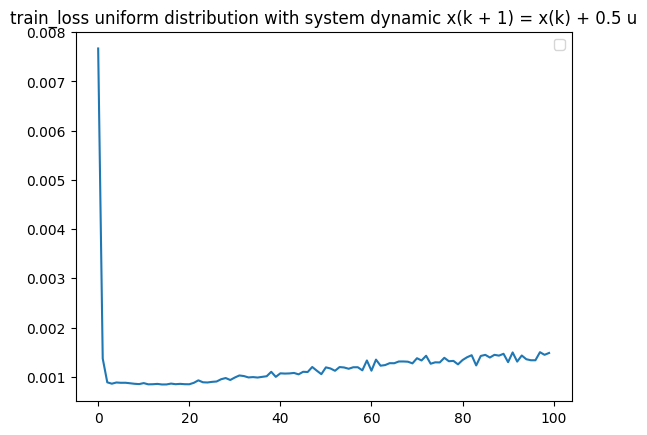

Training Complete!


In [ ]:
import time
epochs = 100  # Number of epochs to train
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    avg_loss = running_loss / (n_samples)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

In [ ]:
#plot trajectory
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



NameError: name 'model' is not defined

In [ ]:
import Ergodic_Loss
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
import importlib
importlib.reload(Ergodic_Loss)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 5 / 3, num_samples = 100000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion.verbose = True
criterion(x = outs, u = control)

tensor([ 1.0000e+00, -9.0785e-04,  1.9201e-03,  2.6349e-03, -9.6312e-04,
        -3.7415e-03,  6.0854e-03,  2.7045e-03,  1.3448e-03,  1.0747e-03,
        -6.2643e-03,  3.3383e-03, -2.7511e-03,  1.2237e-03, -6.8647e-05,
        -5.3557e-03]) target distribution
model tensor([[ 1.0000,  0.1403, -0.1934, -0.2008, -0.0804,  0.0289, -0.0285, -0.0610,
          0.0655,  0.0830, -0.0048, -0.0349,  0.0189, -0.0102, -0.0252, -0.0291]],
       grad_fn=<CopySlices>) target tensor([ 1.0000e+00, -9.0785e-04,  1.9201e-03,  2.6349e-03, -9.6312e-04,
        -3.7415e-03,  6.0854e-03,  2.7045e-03,  1.3448e-03,  1.0747e-03,
        -6.2643e-03,  3.3383e-03, -2.7511e-03,  1.2237e-03, -6.8647e-05,
        -5.3557e-03])
scaling tensor([1.0000e+00, 9.2000e-02, 2.4705e-02, 1.1133e-02, 6.2927e-03, 4.0365e-03,
        2.8066e-03, 2.0635e-03, 1.5806e-03, 1.2493e-03, 1.0122e-03, 8.3666e-04,
        7.0312e-04, 5.9917e-04, 5.1668e-04, 4.5011e-04])


tensor(0.0632, grad_fn=<AddBackward0>)

In [ ]:
criterion(x = outs, u = control)

model tensor([[ 1.0000,  0.1603, -0.1610, -0.1885, -0.0389,  0.0196,  0.0245, -0.0146,
          0.0269,  0.0640,  0.0021, -0.0211,  0.0068,  0.0606, -0.1060, -0.0170]],
       grad_fn=<CopySlices>) target tensor([ 1.0000e+00, -9.0785e-04,  1.9201e-03,  2.6349e-03, -9.6312e-04,
        -3.7415e-03,  6.0854e-03,  2.7045e-03,  1.3448e-03,  1.0747e-03,
        -6.2643e-03,  3.3383e-03, -2.7511e-03,  1.2237e-03, -6.8647e-05,
        -5.3557e-03])
scaling tensor([1.0000e+00, 9.2000e-02, 2.4705e-02, 1.1133e-02, 6.2927e-03, 4.0365e-03,
        2.8066e-03, 2.0635e-03, 1.5806e-03, 1.2493e-03, 1.0122e-03, 8.3666e-04,
        7.0312e-04, 5.9917e-04, 5.1668e-04, 4.5011e-04])


tensor(0.0570, grad_fn=<AddBackward0>)